In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [12]:
test_path = "hdfs://namenode:8020/data/Weather Test Data.csv"
train_path = "hdfs://namenode:8020/data/Weather Training Data.csv"

### Initialize Spark

In [3]:
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession

In [4]:
sc = SparkContext(master="local[*]")

In [5]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [6]:
spark = SparkSession.builder.appName('australian-weather-prediction-spark').getOrCreate()

### Load Dataset

In [13]:
df_train = spark.read.format("csv").option("header", "true").load(train_path)

In [90]:
df_train.count()

99516

In [91]:
removed_duplicates = df_train.distinct()

In [92]:
# no duplicates
removed_duplicates.count()

99516

In [93]:
df_train_data = removed_duplicates.drop("RainTomorrow", "row ID")
df_train_label = removed_duplicates.rdd.map(lambda x: x["RainTomorrow"]).collect()

In [94]:
df_train_data.limit(5).toPandas()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,Albury,15.9,26.2,10.2,None,None,N,24,NE,NA,...,0,82,56,1010.7,1008.6,7,5,17.6,24.7,Yes
1,Albury,4.6,19.9,0,None,None,SW,19,SSW,W,...,11,82,49,1023.8,1021.1,None,None,10.1,19.5,No
2,Albury,7.2,22.9,2.8,None,None,WSW,31,SE,WSW,...,11,55,32,1021.7,1019.7,None,None,13.8,20.8,Yes
3,Albury,17.8,35.5,0,None,None,ENE,31,SSE,ESE,...,11,52,18,1013.2,1009.2,None,None,24.6,34.5,No
4,Albury,15.9,37,0,None,None,NNW,46,ESE,NE,...,15,56,23,1015.2,1010.4,None,None,24.1,35,No


In [95]:
df_train_label[:5]

['0', '0', '0', '0', '0']

### Data Exploration

In [96]:
df_train_data.toPandas().describe().T

,count,unique,top,freq
Location,99516,49,Canberra,2393
MinTemp,99073,386,11,649
MaxTemp,99286,500,20,615
Rainfall,98537,601,0,63047
Evaporation,56985,327,4,2296
Sunshine,52199,145,0,1626
WindGustDir,99516,17,W,6843
WindGustSpeed,93036,67,35,6353
WindDir9am,99516,17,N,8052
WindDir3pm,99516,17,SE,7410


As shown above there are a lot of missing data entries.

In [97]:
from pyspark.sql.functions import col,isnan, when, count

##### List of empty entries for each column

In [98]:
# This shows the list of empty data
df_train_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_train_data.columns]).toPandas().T

,0
Location,0
MinTemp,443
MaxTemp,230
Rainfall,979
Evaporation,42531
Sunshine,47317
WindGustDir,0
WindGustSpeed,6480
WindDir9am,0
WindDir3pm,0


### Plot Categorical Data

In [108]:
# categorical data plotting
categorical_columns = ["Location", "WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]

In [114]:
counter.items()

dict_items([('W', 6843), ('WNW', 5664), ('N', 6323), ('NNE', 4569), ('SW', 6233), ('ENE', 5558), ('SSE', 6329), ('NE', 4956), ('WSW', 6164), ('NNW', 4589), ('S', 6228), ('ESE', 5101), ('NA', 6521), ('NW', 5599), ('E', 6341), ('SSW', 6023), ('SE', 6475)])

In [123]:
def plot_categorical_data(df, column_name, xlabel, title):
    # data
    data = df.rdd.map(lambda x: x[column_name]).collect()
    counter = Counter(data)
    x, y = counter.keys(), counter.values()
    
    # figure
    plt.figure(figsize=(12, 5))
    plt.bar(x, y, width=0.8, align="center")
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel(xlabel)
    plt.xticks(rotation=90)
    
    # plot text
    for i, (key, value) in enumerate(counter.items()):
        plt.text(i, value, f' {value} ', rotation=90, ha='center', va='top', color="white")
    plt.show()

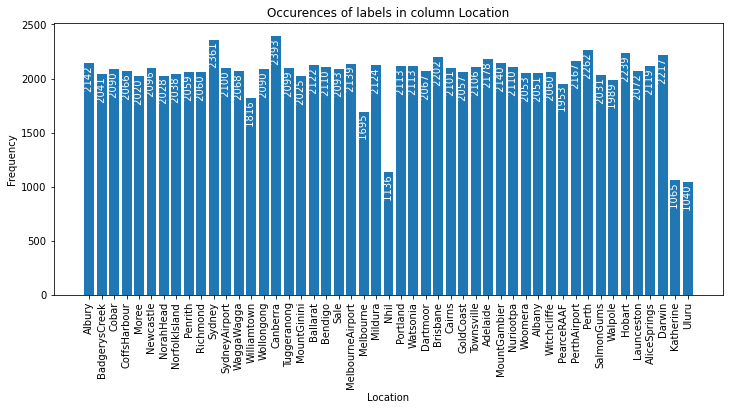

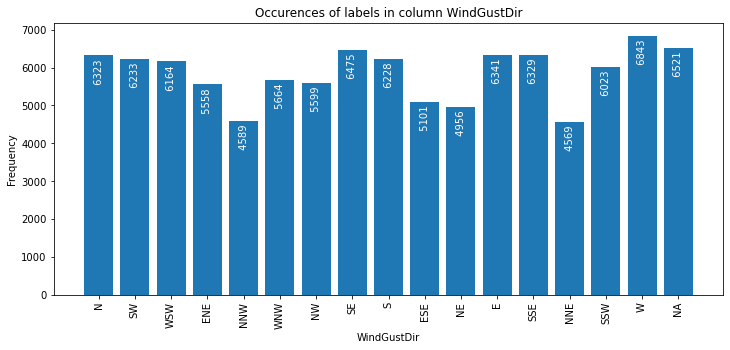

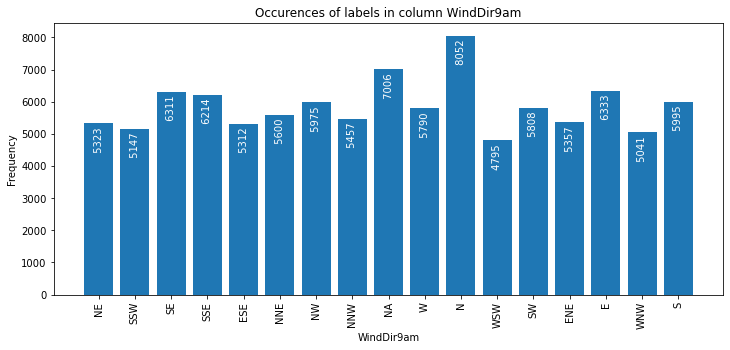

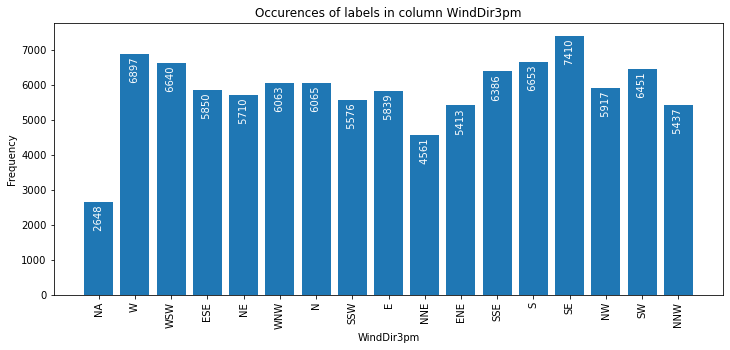

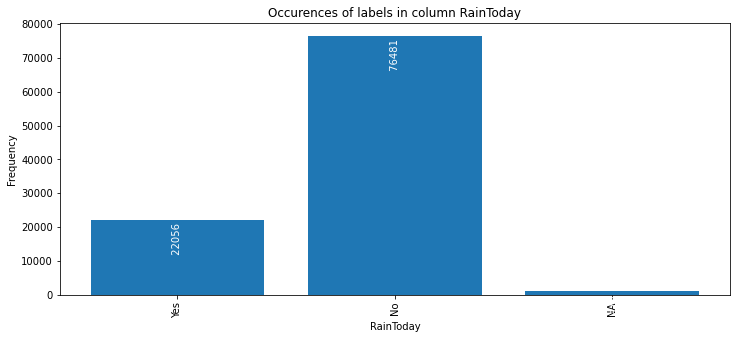

In [124]:
for category in categorical_columns:
    plot_categorical_data(df_train_data, category, category, f"Occurences of labels in column {category}")

### Plot Number Data

In [125]:
int_df = df_train_data.drop(*categorical_columns)

In [126]:
int_df.limit(5).toPandas()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,15.9,26.2,10.2,None,None,24,11,0,82,56,1010.7,1008.6,7,5,17.6,24.7
1,4.6,19.9,0,None,None,19,4,11,82,49,1023.8,1021.1,None,None,10.1,19.5
2,7.2,22.9,2.8,None,None,31,7,11,55,32,1021.7,1019.7,None,None,13.8,20.8
3,17.8,35.5,0,None,None,31,6,11,52,18,1013.2,1009.2,None,None,24.6,34.5
4,15.9,37,0,None,None,46,9,15,56,23,1015.2,1010.4,None,None,24.1,35


#### Distribution

In [155]:
import seaborn as sns
import math

In [165]:
data = int_df.rdd.map(lambda x: float(x["MinTemp"]) if (x["MinTemp"] is not None) else None).collect()

<AxesSubplot:ylabel='Density'>

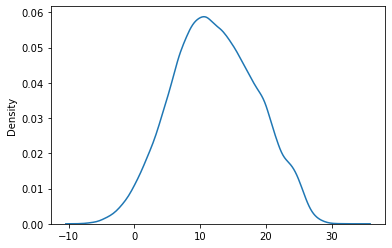

In [166]:
sns.kdeplot(data, ax=axs[i % width, count])

In [163]:
def plot_histogram(df, columns, kind):
    width = math.ceil(len(columns) / 2 )
    fig, axs = plt.subplots(2, width)
    count = 0
    
    for i, column in enumerate(columns):
        if i >= width:
            count += 1
        data = df.rdd.map(lambda x: float(x[column]) if (x[column] is not None) else None).collect()
        if kind = "kde":
            sns.kde_plot(data, ax=axs[i % width, count])
        sns.displot
        axs[i % width, count].set_title(column)
        
    fig.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-163-4d2e73f61245>, line 10)

In [161]:
# kde for float values
kde = ["MinTemp", "MaxTemp", "Rainfall", "Evaporation", "Sunshine", "Pressure9am", "Pressure3pm", "Temp9am", "Temp3pm"]
# histogram for whole numbers
hist = ["WindGustSpeed", "WindGustSpeed3pm", "Humidity9am", "Humidity3pm", "Cloud9am", "Cloud7am"]

### KDE

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


IndexError: index 2 is out of bounds for axis 0 with size 2

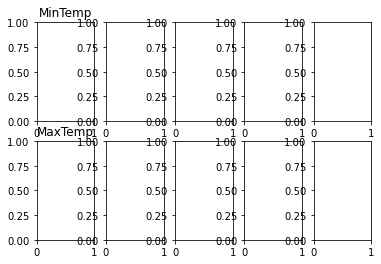

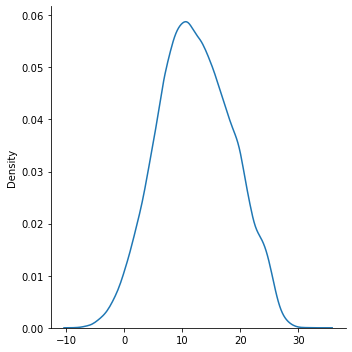

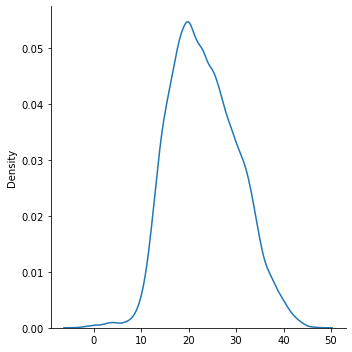

In [162]:
plot_histogram(int_df, kde, "kde")

In [ ]:
for column in hist:
    plot_histogram(int_df, column, "kde")

In [ ]:
plt.figure(figsize=(17,18))
cor = new_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,fmt='.2f')